In [1]:
import sys
sys.path.append(r"/Users/vinuraperera/Documents/mercon_mlops/src")

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import mlflow
import xgboost as xgb
from common.mlflow import setup_mlflow_experiment
from data.load_data import load_cali_house_data, get_features_and_labels
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from common.mlflow import setup_mlflow_experiment

In [4]:
# import os, ssl
# if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
#     getattr(ssl, '_create_unverified_context', None)): 
#     ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
data = load_cali_house_data()


In [6]:
data.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
data.count()


MedInc        20640
HouseAge      20640
AveRooms      20640
AveBedrms     20640
Population    20640
AveOccup      20640
Latitude      20640
Longitude     20640
PRICE         20640
dtype: int64

<Axes: >

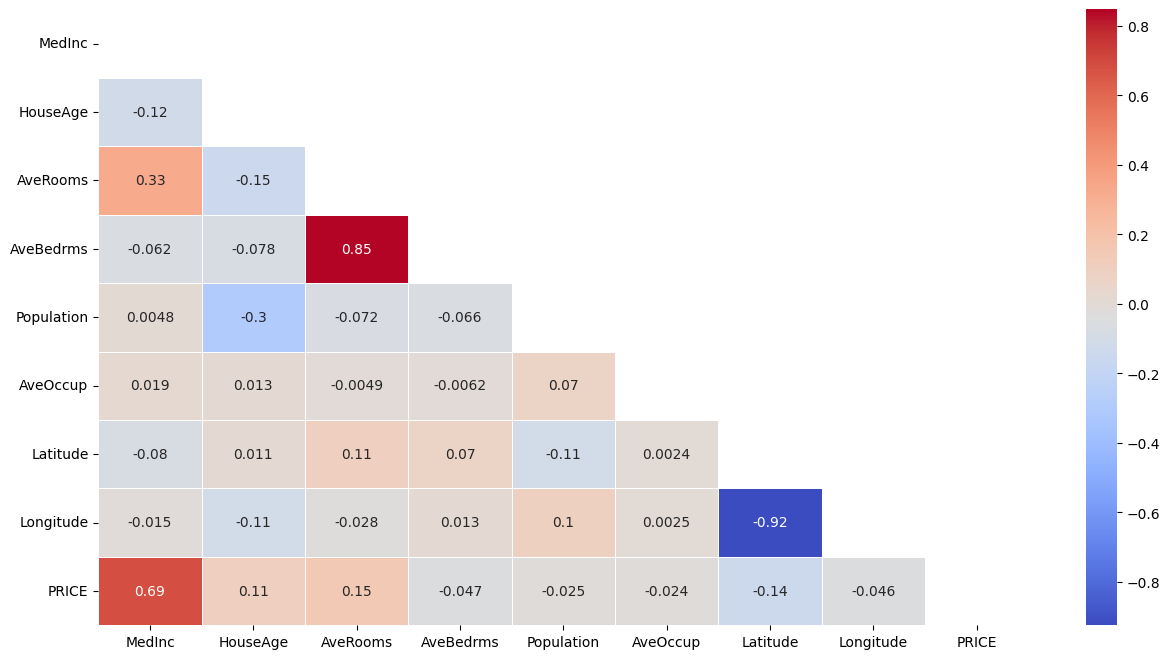

In [8]:
#Obtaining info of the correlations with a heatmap
plt.figure(figsize=(15,8))
corr = data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')


XGB Normal

In [9]:
setup_mlflow_experiment('https://b710-35-237-37-228.ngrok-free.app/', 959816713686281380)


In [12]:
mlflow.autolog(exclusive=False)

with mlflow.start_run():
    data = load_cali_house_data()
    X, y = get_features_and_labels(data)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )
    xg_reg = xgb.XGBRegressor(
        objective="reg:linear",
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        alpha=10,
        n_estimators=10,
    )

    xg_reg.fit(X_train, y_train)

    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mlflow.log_metric("root_mean_squared_error", rmse)


2023/10/24 18:34:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/10/24 18:34:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categ

XGB CV

In [11]:
mlflow.autolog(exclusive=False)

with mlflow.start_run():
    data = load_cali_house_data()
    X, y = get_features_and_labels(data)
    data_dmatrix = xgb.DMatrix(data=X, label=y)

    params = {
        "objective": "reg:squarederror",
        "colsample_bytree": 0.3,
        "learning_rate": 0.1,
        "max_depth": 6,
        "alpha": 10,
    }

    cv_results = xgb.cv(
        dtrain=data_dmatrix,
        params=params,
        nfold=3,
        num_boost_round=50,
        early_stopping_rounds=10,
        metrics="rmse",
        as_pandas=True,
        seed=123,
    )

    test_rmse = cv_results["test-rmse-mean"].tail(1)
    xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

    mlflow.log_metric("root_mean_squared_error", test_rmse)

2023/10/24 18:32:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/10/24 18:32:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/vinuraperera/Documents/mercon_mlops/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categ

In [13]:
MODEL_NAME = "xgb_california"
STAGE = "Staging"

In [14]:
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{STAGE}")

2023/10/24 18:36:37 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - xgboost (current: 2.0.1, required: xgboost==2.0.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [30]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()

In [44]:
client.get_latest_versions("xgb_california")

[<ModelVersion: aliases=[], creation_timestamp=1698152747301, current_stage='Staging', description='', last_updated_timestamp=1698152757147, name='xgb_california', run_id='07316c22256d45f19eb0e0df637573d2', run_link='', source='mlflow-artifacts:/959816713686281380/07316c22256d45f19eb0e0df637573d2/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>,
 <ModelVersion: aliases=[], creation_timestamp=1698154563010, current_stage='None', description='', last_updated_timestamp=1698154563010, name='xgb_california', run_id='0619ab4da59f47238f74dc99bca2f806', run_link='', source='mlflow-artifacts:/959816713686281380/0619ab4da59f47238f74dc99bca2f806/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>]